In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab08.ipynb")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
!pip install lifelines
from lifelines.plotting import plot_lifetimes # Lifeline package for the Survival Analysis

%matplotlib inline
plt.figure(figsize=(12, 6));
pd.set_option('display.max_columns', None)

<Figure size 1200x600 with 0 Axes>

# Lab 8: Survival Analysis

In this lab, we will look at the concept of survival analysis. Survival analysis looks at the time until an event occurs (failure) or we lose them from the sample (censored observation). As economists, we are interested in how long they stay in the sample (survival). We are also interested in the risk of failure (hazard rates).

Some applications of survival analysis include:
 * Firm survival and exit from a market.
 * Time to retirement.
 * How long a machine will last.
 * Likelihood a patient will survive after receiving a diagnosis or treatment.
 * How long before a customer will [change companies or _churn_](https://en.wikipedia.org/wiki/Churn_rate).

## Math/Statistics Intuition

Let's take a non-negative continuous random variable $T$ to represent time.

As a continuous random variable, $T$ has both a probability density function (pdf) and a cumulative density function (cdf). $T$ will have pdf $f(t)$ and cdf $F(T)$.

Using the properties of pdfs, we can express the cdf as:

$$F(t)=P(T<t)$$

In this, $F(t)$ gives us the probability that the event has occured by duration $t$. This also means that $F(t)$ gives us the proportion of population with the time to event value less than $t$.

We can also express the cdf as an integral of the pdf:

$$\int_{0}^{t}f(x)dx$$



**Survival Function**

Using the cdf, we can calculate the survival function, or the probability that the event has not occurred by the time $t$. This means that, S(t) gives us the proportion of population with the time to event value more than t. The survival function looks like:

$$S(t)=1-F(t)=P(T\geq t)$$

We can also express this as an integral:

$$\int_{t}^{\infty}f(x)dx$$

**An example S(t)**


<center>
<img src="img/survival_analysis.png" alt="Survival Analysis" width="600" height="300">
Credit: Anurag Pandey (Edited)
</center>

**How to Estimate S(t)**

Because we don't know the true cdf or pdf for the event we are analyzing, we will use a statistical tool called the Kaplan-Meier estimate to help us.

## Kaplan-Meier Estimate

As mentioned above, we will likely not have the cdf or pdf available for a real world application of survival analysis. Rather, we will have to estimate the survival function from the available data. For this, we will utilize a **Kaplan-Meier Estimate**. 

$$\hat{S}=\prod_{i:t_{i}\leq t}\frac{n_{i}-d_{i}}{n_{i}}$$

In the estimate, denoted by $\hat{S}$, $n_{i}$ is the population at risk at the time just prior to $t_{i}$. $d_{i}$ is the number of events that have occured at time $t_{i}$.

For this notebook, we will be using Python to help us do the calculations. Don't worry if the formula is a little difficult to understand. The basic idea to know is that we are creating a survival curve (like the example given above) using observed data.

In [3]:
# import Kaplan-Meier estimator
from lifelines import KaplanMeierFitter

Let's look at an example using some toy data. As mentioned above, we'll be using the `lifelines` Python package to help us compute these survival curves.

In [4]:
# Example Data 

# how long did they survive (if they survive till the end, put max here)
sample_durations = [5, 6, 6, 2.5, 4, 4]    

# did an event occur (aka did they leave?) within the observation period
sample_event_observed = [1, 0, 0, 1, 1, 1]

In this example data: one entity survived till $T=2.5$, two entities survived till $T=4$, one entity survived till $T=5$, and the other two survived the entire observation period. Let's see what survival curve will the Kaplan-Meier estimator generate. 

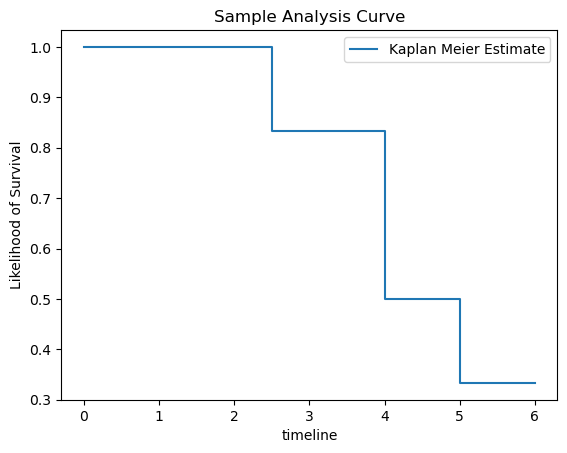

In [5]:
# create an kmf object
kmf = KaplanMeierFitter() 

# Fit the data into the model
kmf.fit(sample_durations, sample_event_observed, label='Kaplan Meier Estimate')

# Create an estimate
kmf.plot(ci_show=False)
plt.title('Sample Analysis Curve')
plt.ylabel('Likelihood of Survival');

See how the survival curve approximates the data we have observed? Now that we have seen this in action, let's take a look at a real world example using some more complex data.

---
## Section 1: Telco Customer Churn

This dataset looks at customer churn for a telco company.

The data set includes information about:
 * Customers who left within the last month – the column is called `Churn`
 * Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
 *  Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
 *  Demographic info about customers – gender, age range, and if they have partners and dependents


Let's read in the data and take a look at the first couple of rows. The data comes from Kaggle and can be accessed [here](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

In [13]:
telco = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [7]:
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Because the Kaplan-Meier process requires numeric values for the features we use, we'll have to do some cleaning and transformations. We'll also have to fill in some NaN values. 

There are a couple of issues we notice about this dataset. 

**1. "Yes" and "No" are very hard to process**  
We should replace them with 0 (for "No") and 1 (for "Yes"). Replace **only** the `Churn` column (since this is the column we will use).

**2. Column `TotalCharges` has object type, but it should contain numerical values**  
We should convert the column to numerical values while handling the errors along the way. Then fill the missing values with the median of the column. 

**Question 1.1:** Handle the issues with `telco` dataset mentioned above.  

*Hint*: when using `pd.to_numeric` function, set the parameter `errors = "coerce"`. 

In [14]:
telco['Churn'] = telco['Churn'].map({'Yes': 1, 'No': 0}).astype('int64')
telco['TotalCharges'] = pd.to_numeric(telco['TotalCharges'], errors='coerce')
total_charges_median = telco['TotalCharges'].median()
telco['TotalCharges'].fillna(total_charges_median, inplace=True)
telco.head()

/tmp/ipykernel_155/587163673.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco['TotalCharges'].fillna(total_charges_median, inplace=True)


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

   Churn  
0      0  
1      0  
2      1  
3      0  
4      1

In [15]:
grader.check("q1_1")

q1_1 results: All test cases passed!

Now that we have cleaned the data, let's create a Kaplan-Meier curve. We will do this for you as an example. 

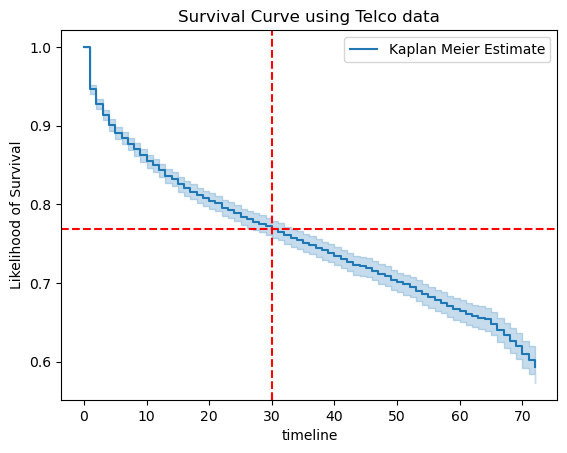

In [16]:
telco_durations = telco['tenure'] 
telco_event_observed = telco['Churn'] 

km = KaplanMeierFitter() 

km.fit(telco_durations, telco_event_observed, label='Kaplan Meier Estimate')

km.plot()
plt.axhline(km.survival_function_at_times(30).item(),color="red",linestyle='dashed')
plt.axvline(30, color="red",linestyle='dashed')
plt.title('Survival Curve using Telco data')
plt.ylabel('Likelihood of Survival');

**What does this curve mean?**

For example, if we look at $t=30$, there is a 76% chance that a customer did not churn, or leave, until that point.

---
## Credit Risk

Let's look at another application of survival analysis: credit risk. Credit Risk refers to the likelihood that a borrower will not be able to repay a loan contracted by a lender. Thus throughout the years, financial institutions have developed various ways to quantify that risk so as to limit their exposure.

Here, instead of simply modeling whether a borrower will repay, by using Survival Analysis, it becomes possible to determine when this will happen. Indeed, it is easy to consider that fully repaying a loan is an explicit event, and therefore not having paid back the loan yet can be defined as the censored situation.

By using this configuration, banks, credit unions, or fintech startups in the lending space can predict the speed of repayment of a loan. This will help these institutions mitigate losses due to bad debt, customize interest rates, improve cash flow and credit collections, and determine which customers are likely to bring in the most revenue throughout a variety of products.

Let's start by reading in the data. The data is sourced from German credit data and comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) and has been reformatted into CSV format [here](https://github.com/square/pysurvival/blob/master/pysurvival/datasets/credit_risk.csv).

In [17]:
credit = pd.read_csv("data/credit_risk.csv")
credit.head()

checking_account_status  duration        credit_history  \
0                 below_0         6      critical_account   
1                0_to_200        48  existing_credit_paid   
2              no_account        12      critical_account   
3                 below_0        42  existing_credit_paid   
4                 below_0        24       delay_in_paying   

               purpose  amount savings_account_status employment_years  \
0             radio_TV    1169                unknown          above_7   
1             radio_TV    5951              below_100      between_1_4   
2            education    2096              below_100      between_4_7   
3  furniture_equipment    7882              below_100      between_4_7   
4              car_new    4870              below_100      between_1_4   

   installment_rate personal_status other_debtors  present_residence  \
0                 4        M_single           NaN                  4   
1                 2    F_not_single           NaN                  2   
2                 2        M_single           NaN                  3   
3                 2        M_single     guarantor                  4   
4                 3        M_single           NaN                  4   

           property  age other_installment_plans housing  number_of_credits  \
0      real_estate    67                     NaN     own                  2   
1      real_estate    22                     NaN     own                  1   
2      real_estate    49                     NaN     own                  1   
3  life_insurance     45                     NaN    free                  1   
4       no_property   53                     NaN    free                  2   

         job  people_liable  telephone  foreign_worker  full_repaid  
0   official              1          1               1            1  
1   official              1          0               1            0  
2  unskilled              2          0               1            1  
3   official              2          0               1            1  
4   official              2          0               1            0

The dataset contains information useful to assess the borrowers creditworthiness as well as socio-demographic elements:

| Feature category | Feature name | Description |
| ----------- | ----------- | ----------- |
| **Time** | `duration` | Duration in month |
| **Event** | `full_repaid` | Specifies if the loan was fully repaid (1 if fully repaid) |
| Bank information | `credit_history` | Credit history of the borrower |
| Socio-Demographic | `age` | Age of the borrower (in years) |
| Socio-Demographic | `telephone` | Indicates if the borrower owns a phone (1 if yes)|
| Residence | `present_residence` | Years living at current residence |
|  |  | ... (other variables omitted) |

See [here](https://square.github.io/pysurvival/tutorials/credit_risk.html) for the full documentation. 

Now that we have read in the data, let's create a baseline survival curve similar to the ones we have seen earlier.

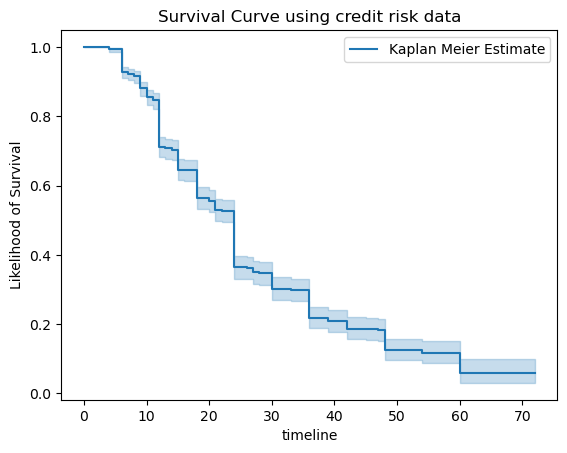

In [18]:
credit_durations = credit['duration'] 
credit_event_observed = credit['full_repaid'] 

km = KaplanMeierFitter() 

km.fit(credit_durations, credit_event_observed, label='Kaplan Meier Estimate')

km.plot()
plt.title('Survival Curve using credit risk data')
plt.ylabel('Likelihood of Survival');

*Recall that the curve describe the duration of the debt (or "survival" of the debt). And ideally, a customer with good credit would repay all the debt as early as possible.*

### Credit History

Now that we have a baseline look at the estimate, let's look at how we can use other features in the dataset to enhance our understanding.

First, let's take a look at how credit history impacts credit risk. We can start by looking at the different possible values that this column has using the `value_counts()` method.

In [19]:
credit["credit_history"].value_counts()

credit_history
existing_credit_paid    530
critical_account        293
delay_in_paying          88
all_credit_paid          49
no_credit_taken          40
Name: count, dtype: int64

We can see that there are 5 different possible values for `credit_history`. Let's take the top 3 and compare their survival curves.

**Question 1.2:** Use `KaplanMeierFitter()` to generate survival curves for the top 3 categories in `credit_history` and then plot the curves on the same graph. Feel free to use the example provided above. 


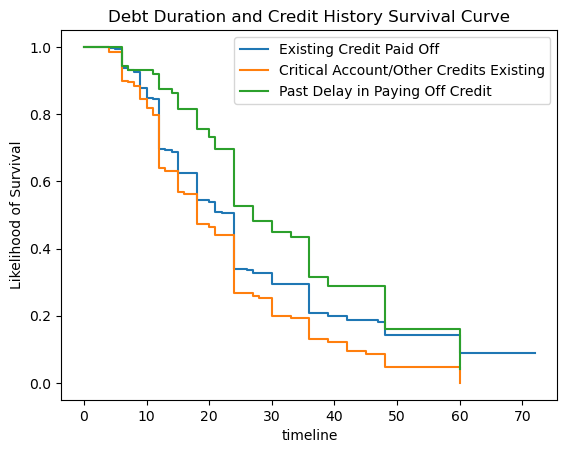

In [20]:
# Group 1: existing_credit_paid
kmf_ch1 = KaplanMeierFitter() 
T1 = credit[credit["credit_history"] == "existing_credit_paid"]['duration']
E1 = credit[credit["credit_history"] == "existing_credit_paid"]['full_repaid']
kmf_ch1.fit(T1, E1, label='Existing Credit Paid Off')   
ax = kmf_ch1.plot(ci_show=False)

# Group 2: critical_account
kmf_ch2 = KaplanMeierFitter() 
T2 = credit[credit["credit_history"] == "critical_account"]['duration']
E2 = credit[credit["credit_history"] == "critical_account"]['full_repaid']
kmf_ch2.fit(T2, E2, label='Critical Account/Other Credits Existing')   
ax = kmf_ch2.plot(ci_show=False)

# Group 3: delay_in_paying 
kmf_ch3 = KaplanMeierFitter() 
T3 = credit[credit["credit_history"] == "delay_in_paying"]['duration']
E3 = credit[credit["credit_history"] == "delay_in_paying"]['full_repaid']
kmf_ch3.fit(T3, E3, label='Past Delay in Paying Off Credit')   
ax = kmf_ch3.plot(ci_show=False)

plt.title("Debt Duration and Credit History Survival Curve")
plt.ylabel('Likelihood of Survival');

In [21]:
grader.check("q1_2")

q1_2 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.3:** Does the result of the graph above align with your intuition? Why or why not?

The graph aligns with my intuition because it shows that people that have past delays in paying off credit are more likely to have debt for longer periods of time and wait the longest to fully pay off their debt as they have the highest survival curve. People with critical accounts have the lowest survival curve and pay off their debt fastest because they are often in more urgent situations where paying off debt matters more or else they may face reprocussions. People with existing credit paid off are in the middle of the two, as they are neither of the two extremes and lie somewhere in the middle. 

<!-- END QUESTION -->

You should see that those with prior delays in paying off their credit are more likely to pay their debt slower and therefore are deemed a credit risk sooner. Does this result align with your intuition?

### Telephone Ownership

Now that we have seen an example of how to use the `lifelines` package, let's look at how telephone ownership impacts credit risk. 

Let's start by using the `value_counts` on the `telephone` column of the `credit` dataframe.

In [22]:
credit["telephone"].value_counts()

telephone
0    596
1    404
Name: count, dtype: int64

**Question 1.4:** Use `KaplanMeierFitter()` to generate survival curves for the both categories in `telephone` and then plot the curves on the same graph. 

*Note:* You must fit `kmf_has_phones` and `kmf_no_phones` in order to pass the autograder.

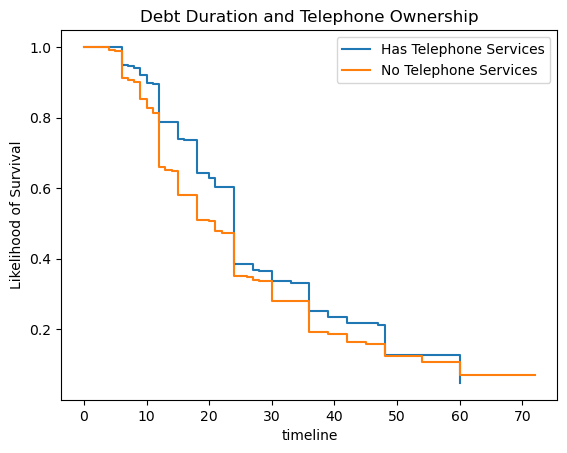

In [24]:
kmf_has_phones = KaplanMeierFitter()
kmf_no_phones = KaplanMeierFitter() 
kmf_no_phones.fit(credit[credit["telephone"] == 0]['duration'], 
                   credit[credit["telephone"] == 0]['full_repaid'], label = "No Telephone Services")

kmf_has_phones.fit(credit[credit["telephone"] == 1]['duration'], 
                   credit[credit["telephone"] == 1]['full_repaid'], label = "Has Telephone Services")

ax = kmf_has_phones.plot(ci_show=False)
ax = kmf_no_phones.plot(ci_show=False)
plt.title("Debt Duration and Telephone Ownership");
plt.ylabel('Likelihood of Survival');

In [25]:
grader.check("q1_4")

q1_4 results: All test cases passed!

**Question 1.5:** According to the survival curves, those who have a phone are _________ to fully repay their loans. 

Fill in the blank with either _faster_ or _slower_.

1. faster
2. slower

Assign the number corresponding to your answer to `q1_4` below.

In [26]:
q1_5 = 2

In [27]:
grader.check("q1_5")

q1_5 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.6:** Does this align with your intuition? What are some possible reasons for this to be the case?

This doesn't align with my intution because I'd think that people with telephones typically are doing financially better than people without telephone services and therefore are able to pay off their debt more easily and at a faster pace. When looking at my analysis, telephone service users have a mean of 4220 compared to 2627 for the amount of their service. This is a big difference that would change how fast loans are paid as large loans will be paid slower compared to smaller loans.

<!-- END QUESTION -->

You can use the following cell as a scratch cell to play around with the `credit` data. Some strategies to come up with possible explanations involve using the `groupby()` method to see if there are any other differences between phone owners and non-phone owners. You can also use matplotlib's `plt.scatter()` method to visualize the data to identify differences. Another way is to look at a few of the data points for both phone owners and non-phone owners. 

In [32]:
credit.groupby("telephone")['amount'].mean()

telephone
0    2627.840604
1    4220.457921
Name: amount, dtype: float64

---
## Section 2: Survival Regression

Now let's regress other covariates on duration. In this example, we'll be using Cox's proportional hazard model for regression. Cox’s proportional hazard model states that the log-hazard of an individual is a linear function of their covariates and a population-level baseline hazard that changes over time. Mathematically:

$$\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{b_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i (x_i - \overline{x_i})\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}$$

Don't worry if you don't fully understand how to math works. It is important to note that the Cox model _does not use an intercept term_ as the baseline hazard represents the intercept. Let's walkthrough an example of survival regression in action.

In [33]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(credit, duration_col='duration', event_col='full_repaid', formula ="age + present_residence");

Here we have fit a model that looks like

$$\text{Duration}_i = \beta_1 * \text{Age}_i + \beta_2 * \text{Present\_Residence}_i$$

We achieve this by adding our right side of the equation to the `formula` parameter in the format of `"variable_1 + variable_2"` as shown above.

Remember that there is no intercept term. We can look at the regression output using the `summary()` method. This regression output should look similar to other ones we have seen in this course and other econometric classes.

In [34]:
cph.summary

coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                          
age                0.009584   1.009630  0.003445        0.002831   
present_residence -0.051758   0.949559  0.035235       -0.120817   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
age                      0.016337             1.002835             1.016471   
present_residence        0.017301             0.886196             1.017451   

                   cmp to         z         p  -log2(p)  
covariate                                                
age                   0.0  2.781762  0.005406  7.531096  
present_residence     0.0 -1.468953  0.141846  2.817608

Using the coefficients from the table, we can see that our model from above has coefficients:

$$duration = \underbrace{0.009584}_{(0.003445)}* age+  \underbrace{-0.051758}_{(0.035235)}* present\_residence$$

What does this mean in the context of debt duration and credit risk? For every additional year in age, the debt duration increases by 0.009584 month. For every additional year in the present residence, the debt duration is lowered by 0.051758 month. 

Intuitively, this makes sense, as people who are older and may have retired may be unable to make their payments as fast. Similarly, for those who have lived in their present residence for a longer time may indicate that they are better able to make their payments and not default.

---

Now's explore how telephone ownership status impacts credit default risk. 

**Question 2.1:** Use the `age` and `telephone` variables in a regression model. Remember to put a `+` in between each variable in the forumla. Reference the example above if you need a quick reminder on the syntax.

In [35]:
cph = CoxPHFitter()
cph.fit(credit, duration_col='duration', event_col='full_repaid', formula ="age + telephone");
cph.summary

coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
age        0.009708   1.009755  0.003325        0.003190        0.016225   
telephone -0.245381   0.782407  0.077616       -0.397505       -0.093256   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
age                   1.003195             1.016357     0.0  2.919412   
telephone             0.671995             0.910960     0.0 -3.161475   

                  p  -log2(p)  
covariate                      
age        0.003507  8.155578  
telephone  0.001570  9.315277

In [36]:
grader.check("q2_1")

q2_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2.2:** In the cell below, explain the regression summary. How do `age` and `telephone` affect loan duration? Are the findings significant? How do you interpret these findings in relation to your answer from 1.5?

The age column coefficient of 0.0009708 shows that as each additional age increase, the debt duration increases by 0.0009708 months. The telephone coefficient shows that having a telephone service will decrease debt duration by 0.245381 months compared to not having a telephone service. The findings are significant as the p values are less than 0.5. In my an

<!-- END QUESTION -->

 

**Congratulations!** You have successfully finished lab 8.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)